In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import r2_score as R2, mean_absolute_error as MAE, mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder


In [2]:
# Load the dataset
df = pd.read_csv('DataFinalProject.csv')

In [3]:
# Dropping unnecessary columns
col=['Ref_ID','Ref_DOI_number', 'Perovskite_deposition_solvents']
df.drop(columns=col, inplace=True)

In [4]:
# Select feature list and target variable
X = df.iloc[:,1:-4]  # Features
y = df.iloc[:,-4:]   # Target Variables: 'JV_default_Voc','JV_default_Jsc', 'JV_default_FF', 'JV_default_PCE'


In [5]:

# Convert string thickness data to float
def convert_to_num(val):
    """
    Some thickness data have individual layer thickness seperated by '|' which are considered as string type data.
    This function takes the sum of each layer and converts it into float type data. 
    """
    if isinstance(val, str):
        # split the string by '|'
        nums = val.split('|')
        # convert each element to float and sum them up
        total = sum([float(num) if num != 'nan' else 0 for num in nums])
        # return empty string if total is 0, else return the total
        return np.nan if total == 0 else total
    # if the value is not a string, return the original value
    return val

In [6]:
# Seperating features of different datatypes
numerical = list(X.select_dtypes(include='float64')) 
categorical = list(X.select_dtypes(include='object'))

In [7]:

X[categorical] = X[categorical].astype('category')

In [8]:
X_Jsc, X_Voc, X_FF, X_PCE = X.copy(), X.copy(), X.copy(), X.copy() # Four copy of features columns
y_Jsc, y_Voc, y_FF, y_PCE = y['JV_default_Jsc'], y['JV_default_Voc'], y['JV_default_FF'], y['JV_default_PCE'] # Copy of Target variables


In [9]:
TE_PCE=TargetEncoder() #Loading target encoder for PCE
TE_PCE.fit(X_PCE[categorical],y_PCE) # Fitting encoder with PCE column
X_PCE[categorical]=TE_PCE.transform(X_PCE[categorical]) #Encoding categorical features

In [10]:
df_PCE = pd.concat([X_PCE,y_PCE],axis=1) # Joining target variable column with encoded feature columns

In [11]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_PCE)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = TTS(X_scaled, y_PCE, test_size=0.2, random_state=42)

# Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# SVM model
svm = SVR()
svm.fit(X_train, y_train)

# XGBoost model
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_r2 = R2(y_train, train_pred)
    test_r2 = R2(y_test, test_pred)
    train_mae = MAE(y_train, train_pred)
    test_mae = MAE(y_test, test_pred)
    train_rmse = np.sqrt(MSE(y_train, train_pred))
    test_rmse = np.sqrt(MSE(y_test, test_pred))
    return train_r2, test_r2, train_mae, test_mae, train_rmse, test_rmse

In [14]:
def parity_plot(model, X_train, X_test, y_train, y_test, model_name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, train_pred, c='blue', edgecolor='k', label='Train')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Train Set - {model_name}')
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, test_pred, c='red', edgecolor='k', label='Test')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Test Set - {model_name}')
    
    plt.tight_layout()
    plt.show()


In [15]:
rf_metrics = evaluate_model(rf, X_train, X_test, y_train, y_test)
svm_metrics = evaluate_model(svm, X_train, X_test, y_train, y_test)
xgboost_metrics = evaluate_model(xgboost, X_train, X_test, y_train, y_test)


In [16]:
# Print metrics
print("Random Forest Metrics:")
print("Train R2:", rf_metrics[0])
print("Test R2:", rf_metrics[1])
print("Train MAE:", rf_metrics[2])
print("Test MAE:", rf_metrics[3])
print("Train RMSE:", rf_metrics[4])
print("Test RMSE:", rf_metrics[5])
print()
print("SVM Metrics:")
print("Train R2:", svm_metrics[0])
print("Test R2:", svm_metrics[1])
print("Train MAE:", svm_metrics[2])
print("Test MAE:", svm_metrics[3])
print("Train RMSE:", svm_metrics[4])
print("Test RMSE:", svm_metrics[5])
print()
print("XGBoost Metrics:")
print("Train R2:", xgboost_metrics[0])
print("Test R2:", xgboost_metrics[1])
print("Train MAE:", xgboost_metrics[2])
print("Test MAE:", xgboost_metrics[3])
print("Train RMSE:", xgboost_metrics[4])
print("Test RMSE:", xgboost_metrics[5])


Random Forest Metrics:
Train R2: 0.43650455627748186
Test R2: 0.34435057569176475
Train MAE: 2.4672026286243973
Test MAE: 2.719160723696801
Train RMSE: 3.4097518343352498
Test RMSE: 3.633667457477803

SVM Metrics:
Train R2: 0.08567361660016826
Test R2: 0.0734769944930761
Train MAE: 3.2245694579631636
Test MAE: 3.2487585739825784
Train RMSE: 4.343383659874622
Test RMSE: 4.319539412661756

XGBoost Metrics:
Train R2: 0.43296587340969717
Test R2: 0.33868552197587065
Train MAE: 2.4747873584995723
Test MAE: 2.7292014835616234
Train RMSE: 3.4204414916174986
Test RMSE: 3.6493318097239364


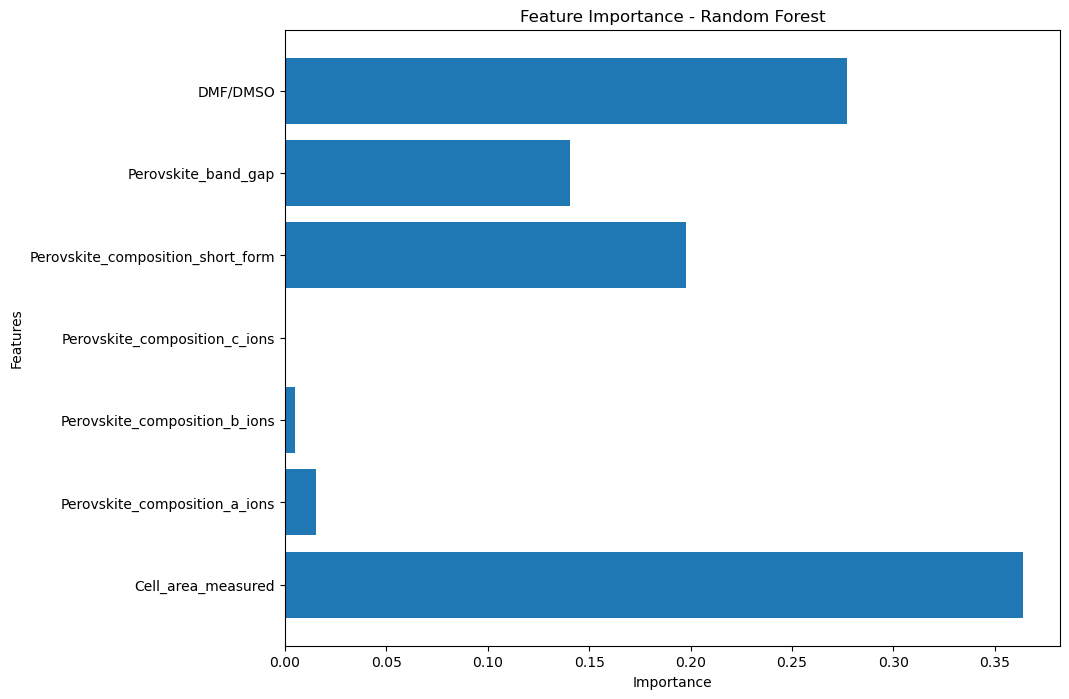

In [17]:
# Feature Importance plot for Random Forest
features = X.columns
importances = rf.feature_importances_

plt.figure(figsize=(10, 8))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.show()


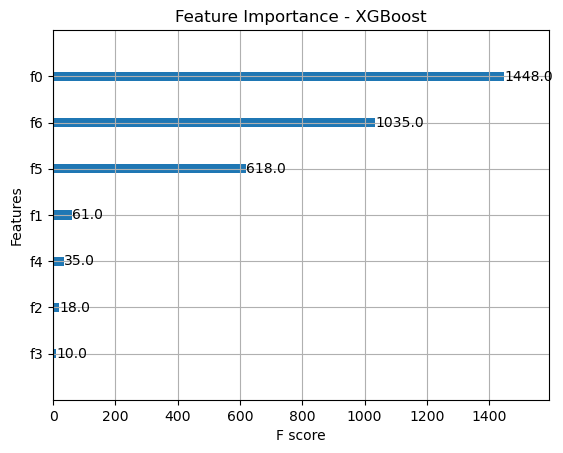

In [18]:
    # Feature Importance plot for XGBoost
xgb.plot_importance(xgboost)
plt.title("Feature Importance - XGBoost")
plt.show()

In [19]:
# Plot for Random Forest
parity_plot(rf, X_train, X_test, y_train[y_PCE], y_test[y_PCE], 'Random Forest')

KeyError: '[0.17, 12.8, 6.5, 8.8, 14.3, 1.98, 2.07, 3.24, 1.1, 1.4, 2.4, 2.72, 4.69, 4.81, 0.09, 4.77, 1.08, 1.17, 0.42, 0.5, 0.75, 0.81, 2.43, 5.17, 5.29, 2.53, 0.58, 1.8, 3.71, 3.93, 6.25, 7.34, 6.07, 5.37, 2.8, 3.64, 3.76, 4.94, 5.34, 5.49, 5.26, 5.85, 6.63, 5.09, 0.1, 0.04, 1.21, 3.67, 14.61, 13.17, 15.63, 17.13, 14.2, 16.32, 17.55, 17.85, 17.34, 17.0, 14.49, 17.56, 19.67, 21.04, 12.31, 10.56, 14.57, 20.05, 19.52, 16.83, 17.16, 18.24, 16.86, 17.5, 18.6, 18.87, 18.89, 16.23, 12.6, 15.16, 17.66, 19.37, 21.26, 19.8, 8.3, 15.1, 15.77, 5.93, 6.27, 10.45, 8.17, 11.23, 12.16, 12.93, 17.42, 6.75, 14.01, 14.4, 16.18, 13.9, 14.5, 16.2, 14.9, 14.36, 10.38, 13.97, 7.26, 9.15, 11.67, 6.97, 13.22, 18.02, 17.7, 10.4, 15.02, 13.24, 13.02, 9.78, 12.35, 10.86, 16.89, 16.28, 17.27, 18.23, 17.2, 18.36, 17.3, 16.87, 12.23, 16.47, 16.68, 16.69, 12.7, 15.7, 16.5, 17.6, 16.3, 16.1, 18.8, 18.9, 0.48, 5.01, 9.13, 8.51, 11.7, 16.15, 16.08, 18.06, 14.23, 16.67, 16.22, 15.71, 18.18, 18.76, 17.31, 20.26, 16.57, 18.01, 6.67, 14.64, 4.62, 9.33, 15.06, 15.49, 2.87, 18.59, 17.81, 18.16, 19.26, 9.11, 19.7, 12.36, 11.42, 12.13, 13.03, 13.83, 15.34, 10.44, 12.42, 14.6, 15.67, 4.3, 4.6, 5.86, 5.31, 5.52, 4.2, 5.28, 5.97, 5.24, 5.41, 6.76, 13.08, 13.5, 14.52, 13.4, 14.05, 14.66, 14.37, 14.08, 12.53, 15.94, 15.87, 18.53, 8.11, 9.4, 13.74, 14.12, 14.76, 15.43, 15.27, 14.8, 16.63, 16.27, 16.51, 17.09, 14.22, 15.93, 17.38, 17.79, 18.44, 18.57, 18.94, 18.1, 10.3, 13.7, 9.97, 13.49, 15.15, 15.96, 15.57, 16.71, 17.64, 17.73, 16.01, 16.44, 16.56, 17.43, 18.21, 10.7, 12.65, 7.82, 10.39, 12.92, 14.63, 13.2, 15.51, 15.91, 16.36, 16.09, 16.99, 10.35, 15.46, 14.04, 8.98, 11.06, 10.05, 11.77, 13.39, 7.2, 12.5, 13.3, 16.8, 14.75, 1.04, 1.18, 7.32, 9.31, 10.6, 8.09, 10.21, 10.23, 11.12, 10.92, 13.54, 14.99, 12.71, 14.51, 4.76, 9.96, 7.65, 6.19, 18.7, 8.13, 12.79, 15.9, 11.5, 1.94, 2.45, 3.4, 3.53, 6.42, 6.78, 5.57, 6.43, 9.5, 9.01, 20.63, 12.87, 9.89, 11.75, 13.01, 1.15, 8.07, 10.51, 13.18, 11.08, 11.73, 14.15, 15.2, 16.46, 9.23, 14.1, 15.3, 17.9, 20.3, 11.6, 10.5, 17.8, 14.82, 17.52, 18.26, 18.08, 18.71, 20.41, 5.6, 3.6, 7.93, 17.88, 19.3, 18.75, 19.2, 12.66, 14.45, 14.48, 14.68, 5.25, 3.26, 6.66, 9.67, 19.57, 14.7, 17.1, 16.4, 17.35, 20.02, 16.9, 13.95, 17.11, 17.94, 7.74, 8.9, 9.57, 10.64, 11.62, 15.08, 4.15, 5.46, 14.33, 17.36, 18.34, 14.26, 11.34, 12.4, 12.06, 13.29, 5.87, 6.23, 7.03, 7.62, 10.13, 10.49, 15.32, 10.94, 11.84, 11.53, 15.29, 15.92, 15.74, 15.64, 17.14, 15.39, 15.6, 18.35, 18.74, 19.02, 20.28, 11.19, 17.4, 18.3, 2.95, 10.07, 6.53, 19.71, 13.41, 14.87, 13.38, 10.2, 14.32, 8.99, 16.12, 7.39, 3.7, 16.19, 13.31, 12.47, 15.4, 3.34, 9.68, 13.13, 13.16, 17.01, 6.94, 14.34, 17.54, 18.37, 16.62, 16.07, 6.64, 13.82, 19.18, 18.91, 14.91, 15.85, 17.44, 2.3, 9.7, 7.6, 10.9, 10.63, 12.97, 15.48, 11.31, 9.9, 6.01, 11.91, 15.54, 15.18, 15.8, 15.12, 15.98, 16.54, 17.03, 10.71, 7.21, 6.51, 14.58, 14.88, 17.82, 8.2, 8.0, 14.86, 15.89, 16.11, 13.93, 16.7, 18.51, 8.47, 5.96, 4.63, 5.98, 4.78, 6.02, 5.95, 6.62, 9.3, 9.1, 11.8, 8.7, 12.9, 17.98, 19.87, 18.58, 11.2, 19.61, 13.19, 13.6, 14.21, 10.31, 10.61, 9.85, 11.03, 11.1, 11.48, 13.46, 12.34, 11.63, 8.4, 16.74, 15.5, 17.04, 18.2, 0.01, 0.016, 10.1, 9.55, 11.9, 14.94, 15.07, 15.99, 20.06, 18.68, 20.97, 18.73, 18.45, 19.39, 20.49, 19.33, 19.5, 21.07, 20.4, 20.55, 19.76, 20.8, 22.2, 12.3, 10.8, 12.03, 18.05, 18.17, 15.61, 17.92, 20.52, 16.6, 18.5, 14.73, 13.06, 14.84, 17.17, 11.3, 20.1, 8.93, 11.99, 17.49, 17.19, 5.03, 12.67, 10.85, 7.09, 8.65, 10.24, 17.48, 16.53, 18.42, 18.69, 16.24, 15.79, 5.8, 7.07, 6.9, 6.3, 8.1, 8.42, 11.76, 12.68, 14.83, 15.82, 18.43, 17.83, 16.97, 12.29, 11.22, 17.28, 18.4, 17.93, 19.13, 20.2, 15.38, 12.0, 18.12, 19.6, 17.29, 19.82, 20.24, 19.31, 21.4, 12.2, 16.55, 18.88, 18.39, 19.89, 19.45, 19.44, 10.73, 16.72, 17.71, 19.01, 20.47, 17.46, 20.14, 12.08, 15.13, 18.48, 21.1, 20.78, 14.81, 18.11, 18.13, 18.96, 17.59, 13.1, 13.27, 16.42, 16.81, 16.04, 16.96, 17.07, 17.39, 18.47, 12.01, 9.05, 8.54, 6.7, 12.1, 19.4, 5.4, 5.5, 17.61, 18.15, 16.94, 17.18, 17.68, 18.19, 18.62, 19.16, 0.004, 0.008, 7.53, 9.76, 13.56, 12.43, 15.72, 12.49, 20.9, 19.05, 17.23, 4.25, 15.59, 1.25, 1.27, 3.45, 5.04, 8.59, 11.58, 15.56, 16.98, 17.95, 20.18, 14.02, 18.52, 19.27, 20.43, 18.49, 19.98, 20.07, 17.25, 19.19, 0.8, 2.2, 4.8, 2.1, 3.5, 5.2, 3.8, 3.3, 7.8, 8.5, 6.8, 13.8, 9.04, 1.73, 9.83, 13.53, 14.74, 14.67, 14.71, 14.25, 16.48, 17.45, 18.66, 18.85, 9.62, 7.5, 20.65, 11.4, 16.02, 17.75, 17.37, 18.67, 18.33, 9.35, 11.45, 7.28, 17.72, 19.1, 18.79, 18.03, 2.5, 7.86, 12.72, 15.25, 17.21, 17.67, 14.98, 12.32, 14.09, 15.03, 17.02, 17.41, 12.77, 18.61, 1.67, 6.4, 15.58, 16.26, 16.91, 17.78, 14.06, 12.14, 9.81, 14.53, 11.95, 5.89, 7.1, 16.75, 8.53, 15.78, 18.81, 15.55, 15.86, 15.05, 13.61, 9.86, 9.8, 10.04, 12.04, 11.29, 15.53, 16.77, 3.27, 7.58, 13.23, 16.61, 15.31, 16.25, 20.03, 20.08, 19.9, 20.16, 5.56, 12.09, 17.62, 15.76, 17.57, 18.31, 8.62, 4.45, 4.93, 9.46, 15.69, 13.87, 17.91, 13.33, 15.04, 12.24, 14.27, 18.46, 16.52, 16.13, 18.22, 19.53, 0.02, 0.07, 0.06, 0.11, 0.12, 14.41, 10.99, 12.11, 13.85, 5.3, 14.95, 11.11, 10.53, 14.93, 3.95, 15.45, 14.97, 16.88, 16.45, 19.38, 0.84, 13.76, 16.37, 15.65, 17.77, 20.23, 19.66, 17.08, 20.34, 19.49, 19.06, 12.62, 20.48, 20.82, 11.88, 12.58, 7.49, 12.55, 13.62, 17.24, 18.56, 16.73, 16.85, 18.25, 19.15, 8.96, 7.68, 6.88, 16.49, 15.09, 14.44, 14.92, 15.52, 15.88, 14.14, 15.11, 13.34, 12.38, 12.44, 2.6, 4.5, 4.9, 4.7, 8.18, 5.59, 16.59, 18.28, 0.51, 8.24, 9.6, 18.41, 13.04, 14.16, 13.55, 16.17, 16.43, 17.22, 18.38, 18.72, 14.13, 10.22, 7.83, 8.49, 8.41, 9.32, 10.14, 9.36, 11.28, 15.47, 13.84, 13.21, 16.06, 14.35, 15.36, 13.37, 14.42, 19.24, 18.63, 14.39, 16.03, 7.56, 8.88, 10.79, 12.83, 13.72, 13.05, 12.19, 13.63, 16.16, 18.14, 15.28, 17.05, 18.82, 11.46, 13.66, 15.84, 0.63, 7.52, 7.92, 4.38, 7.94, 0.24, 7.25, 8.77, 11.33, 11.82, 10.27, 10.33, 12.52, 17.96, 11.92, 14.19, 7.96, 6.95, 9.87, 8.6, 7.3, 15.24, 16.21, 11.15, 11.96, 8.63, 14.29, 2.21, 10.43, 12.26, 12.76, 8.01, 12.95, 11.54, 5.7, 10.32, 16.79, 9.2, 10.84, 12.54, 14.28, 15.42, 5.54, 8.45, 3.85, 7.17, 4.87, 20.17, 13.28, 0.44, 6.45, 9.65, 7.77, 8.43, 11.97, 11.26, 14.77, 15.97, 16.38, 15.44, 10.19, 10.47, 13.94, 13.14, 16.84, 9.44, 9.79, 10.96, 13.15, 13.35, 1.26, 6.57, 6.77, 12.46, 8.32, 11.66, 12.02, 1.47, 1.96, 3.63, 7.04, 11.13, 14.43, 11.43, 12.37, 10.57, 13.25, 13.42, 15.62, 19.36, 16.92, 17.74, 20.6, 3.19, 4.28, 3.09, 3.35, 4.06, 4.17, 1.38, 4.85, 10.95, 3.48, 7.55, 3.04, 4.4, 17.58, 14.59, 13.07, 7.4, 12.74, 14.62, 16.82, 4.09, 13.58, 1.72, 4.86, 5.55, 1.52, 8.34, 10.11, 14.72, 14.24, 13.48, 6.2, 6.87, 17.65, 12.86, 11.38, 13.09, 12.69, 19.09, 16.34, 17.76, 17.99, 3.66, 5.53, 5.47, 10.12, 5.48, 6.17, 6.54, 10.41, 10.59, 11.98, 12.45, 15.41, 11.35, 11.17, 1.2, 14.78, 11.27, 11.74, 10.83, 13.89, 4.41, 14.31, 15.14, 14.18, 17.06, 16.58, 16.95, 18.29, 19.62, 0.03, 1.24, 19.23, 20.29, 16.05, 9.09, 0.74, 17.69, 8.89, 7.66, 20.71, 11.21, 19.81, 20.46, 10.36, 21.33, 15.83, 13.67, 12.21, 12.41, 13.45, 15.01, 16.78, 18.84, 11.49, 12.28, 7.43, 17.47, 13.57, 18.27, 7.85, 7.46, 8.38, 6.99, 9.14, 14.11, 10.18, 8.23, 8.61, 9.16, 9.48, 9.92, 9.61, 11.16, 11.56, 8.97, 11.07, 15.95, 10.69, 6.41, 7.18, 6.69, 7.71, 8.44, 10.15, 4.92, 1.5, 5.1, 9.29, 9.45, 3.2, 7.7, 9.72, 3.99, 3.29, 13.65, 18.09, 11.59, 17.63, 10.29, 13.26, 10.97, 14.89, 7.41, 9.02, 10.54, 15.68, 11.01, 13.86, 15.21, 0.2, 20.5, 9.56, 12.22, 11.94, 2.28, 7.69, 11.32, 6.14, 6.52, 6.56, 6.04, 6.18, 6.74, 6.38, 6.29, 6.26, 6.91, 6.96, 7.08, 12.78, 12.81, 12.99, 15.75, 15.81, 2.68, 6.83, 4.05, 9.22, 11.72, 5.92, 11.57, 17.53, 1.7, 5.63, 9.98, 8.76, 6.61, 18.86, 19.64, 2.18, 16.66, 16.33, 19.43, 18.99, 19.17, 19.25, 19.51, 18.97, 19.55, 20.51, 19.72, 19.78, 19.58, 20.67, 8.26, 0.68, 0.61, 15.33, 7.76, 0.706, 1.57, 2.66, 0.695, 0.642, 7.57, 11.02, 10.67, 12.27, 17.32, 8.92, 2.59, 10.34, 21.08, 11.83, 22.08, 4.01, 3.13, 17.97, 17.87, 11.37, 8.55, 11.89, 13.59, 8.85, 7.67, 12.33, 12.64, 14.47, 4.07, 4.99, 12.12, 11.93, 9.59, 0.52, 13.75, 11.05, 8.74, 14.85, 12.89, 16.64, 16.31, 17.51, 15.35, 18.55, 7.36, 13.11, 15.73, 0.54, 1.63, 8.56, 21.6, 14.69, 16.35, 18.78, 14.46, 11.52, 20.31, 12.63, 5.71, 14.65, 18.83, 19.41, 17.15, 16.93, 17.89, 17.86, 18.77, 20.7, 0.32, 11.69, 11.87, 14.38, 0.9, 1.6, 14.96, 1.36, 3.46, 2.61, 8.28, 8.48, 12.17, 6.34, 16.65, 0.6, 18.98, 19.34, 20.12, 10.26, 11.36, 6.21, 6.49, 7.42, 7.13, 6.58, 8.35, 8.46, 8.33, 8.52, 15.19, 14.54, 16.14, 15.66, 13.64, 18.95, 19.07, 19.08, 20.22, 18.65, 19.35, 19.48, 5.19, 9.21, 7.15, 8.83, 9.75, 13.32, 9.17, 12.84, 7.59, 9.18, 11.65, 9.38, 8.39, 13.71, 5.58, 5.82, 19.11, 14.79, 17.26, 18.54, 1.02, 4.83, 0.57, 15.37, 15.17, 15.26, 18.07, 3.23, 13.81, 13.77, 6.6, 2.91, 1.86, 3.54, 3.52, 5.14, 7.48, 18.32, 18.93, 20.09, 6.37, 6.85, 15.22, 0.71, 12.15, 11.04, 11.09, 12.96, 13.68, 3.12, 19.03, 12.88, 2.82, 11.79, 16.41, 21.02, 19.69, 11.78, 12.82, 19.29, 19.79, 21.31, 3.02, 10.89, 10.98, 11.81, 19.95, 19.74, 0.91, 5.45, 10.46, 17.12, 19.14, 19.42, 19.68, 15.23, 19.04, 20.13, 10.91, 14.03, 3.94, 8.05, 8.84, 0.76, 4.53, 7.33, 8.81, 7.11, 7.02, 11.64, 11.47, 6.1, 19.21, 12.94, 11.85, 8.19, 2.7, 0.29, 10.74, 11.55, 8.08, 0.3637788, 0.1463, 1.07, 3.49, 4.59, 7.63, 7.79, 8.22, 8.94, 8.27, 10.68, 5.08, 7.64, 7.44, 12.51, 4.43, 12.75, 13.88, 4.27, 9.74, 8.91, 6.73, 1.19, 2.74, 3.59, 4.19, 6.84, 4.1, 8.25, 21.2, 21.14, 20.77, 1.84, 3.91, 2.04, 9.43, 13.69, 14.56, 12.18, 5.15, 0.3, 0.31, 0.99, 5.9, 3.73, 0.47, 1.56, 0.05, 7.75, 9.64, 7.73, 7.95, 8.58, 11.44, 7.16, 0.003, 5.44, 5.35, 0.7, 1.03, 1.3, 3.82, 5.61, 5.68, 5.91, 1.95, 2.14, 2.31, 6.28, 7.54, 7.91, 8.29, 2.79, 6.59, 10.08] not in index'

In [ ]:
# Plot for SVM
parity_plot(svm, X_train, X_test, y_train['JV_default_PCE'], y_test['JV_default_PCE'], 'SVM')

In [ ]:
# Plot for XGBoost
parity_plot(xgboost, X_train, X_test, y_train['JV_default_PCE'], y_test['JV_default_PCE'], 'XGBoost')